<div class="alert alert-info">

## **Dataset Analysis**

This notebook will analyze and summarize all different aspects of the dataset.

</div>

In [66]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
import os
import tqdm
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt

from enum import IntEnum
from datetime import timedelta

from video_dataset import VideoDataset
from video_dataset.padder import LastValuePadder
from video_dataset.dataset import VideoShapeComponents
from video_dataset.video import VideoFromVideoFramesDirectory
from video_dataset.preprocessor import extract_frames_from_videos
from video_dataset.annotations import AnnotationsFromSegmentLevelCsvFileAnnotations

from tas_helpers.visualization import SegmentationVisualizer
from tas_helpers.scores import repetition_score, order_variation_score
from tas_helpers.metrics import mean_over_frames, f1_score, edit_distance

from cached_dataset.dataset import DiskCachedDataset

from utils import LabelEncoderFactory

In [68]:
VIDEO_FPS = VIDEO_FPS

DATASET_PATH = "/Users/nadir/Documents/research-project-dataset"

VIDEOS_DIRECTORY_NAME = "videos"
ANNOTATIONS_DIRECTORY_NAME = "annotations"
VIDEOS_FRAMES_DIRECTORY_NAME = "videos_frames"

ALL_IDS_FILE_NAME = "all_ids.txt"
TESTING_IDS_FILE_NAME = "testing_ids.txt"
TRAINING_IDS_FILE_NAME = "training_ids.txt"
VALIDATION_IDS_FILE_NAME = "validation_ids.txt"

ANNOTATED_IDS_FILE_NAME = "annotated_ids.txt"
UNANNOTATED_IDS_FILE_NAME = "unannotated_ids.txt"

In [69]:
label_encoder = LabelEncoderFactory.get()

In [70]:
def __aggregate_labels(str_labels):
    labels = label_encoder.transform(str_labels)
    
    unique_elements, counts = np.unique(labels, return_counts=True)

    max_count_index = np.argmax(counts)

    most_frequent_element = unique_elements[max_count_index]
    
    return most_frequent_element

In [71]:
all_videos_dataset = VideoDataset(
    annotations_dir=os.path.join(DATASET_PATH, ANNOTATIONS_DIRECTORY_NAME),
    videos_dir=os.path.join(DATASET_PATH, VIDEOS_FRAMES_DIRECTORY_NAME),
    ids_file=os.path.join(DATASET_PATH, ALL_IDS_FILE_NAME),
    segment_size=32,
    video_processor=VideoFromVideoFramesDirectory,
    annotations_processor=AnnotationsFromSegmentLevelCsvFileAnnotations,
    annotations_processor_kwargs={"fps": VIDEO_FPS, "delimiter": ","},
    video_shape=(VideoShapeComponents.CHANNELS, VideoShapeComponents.TIME, VideoShapeComponents.HEIGHT, VideoShapeComponents.WIDTH),
    step=1,
    # padder=LastValuePadder(),
    annotations_transform=__aggregate_labels,
    overlap=0,
    allow_undefined_annotations=True,
    verbose=False
)

In [72]:
annotated_videos_dataset = VideoDataset(
    annotations_dir=os.path.join(DATASET_PATH, ANNOTATIONS_DIRECTORY_NAME),
    videos_dir=os.path.join(DATASET_PATH, VIDEOS_FRAMES_DIRECTORY_NAME),
    ids_file=os.path.join(DATASET_PATH, ANNOTATED_IDS_FILE_NAME),
    segment_size=VideoDataset.FULL_VIDEO_SEGMENT,
    video_processor=VideoFromVideoFramesDirectory,
    annotations_processor=AnnotationsFromSegmentLevelCsvFileAnnotations,
    annotations_processor_kwargs={"fps": VIDEO_FPS, "delimiter": ","},
    video_shape=(VideoShapeComponents.CHANNELS, VideoShapeComponents.TIME, VideoShapeComponents.HEIGHT, VideoShapeComponents.WIDTH),
    step=1,
    # padder=LastValuePadder(),
    # annotations_transform=__aggregate_labels,
    overlap=0,
    allow_undefined_annotations=True,
    load_videos=False
)

In [73]:
print(f"[dataset-size]: {len(annotated_videos_dataset)}")

[dataset-size]: 22


<div class="alert alert-info">

#### **Dataset Total Duration:**

</div>

In [74]:
fps = VIDEO_FPS

all_annotations = [annotation for _, video_annotations in annotated_videos_dataset for annotation in video_annotations]

total_number_of_frames = len(all_annotations)

duration = total_number_of_frames / fps
formatted_duration = str(timedelta(seconds=int(duration)))

print(f"[total_number_of_frames]: {total_number_of_frames}")
print(f"--- --- ---")
print(f"[duration(hours:minutes:seconds)]: {formatted_duration}")

[total_number_of_frames]: 133490
--- --- ---
[duration(hours:minutes:seconds)]: 1:28:59


<div class="alert alert-info">

#### **Repetition Score:**

</div>

In [75]:
repetition_scores = [repetition_score(annotations) for _, annotations in annotated_videos_dataset]

average_repetition_score = np.mean(repetition_scores)
std_repetition_score = np.std(repetition_scores)
    
print(f"[repetition-score]: {average_repetition_score} ± {std_repetition_score}")

[repetition-score]: 0.8131712451488049 ± 0.03650003778074824


<div class="alert alert-warning">

The repetition score ranges between 0 and -1. A higher value such as in our case signifies a higher degree of repetition within the sequences. In simple words, actions usually repeat in the sequence / activity.

</div>

<div class="alert alert-info">

#### **Order Variation Score:**

</div>

In [76]:
videos_annotations = [annotations for _, annotations in annotated_videos_dataset]

order_variation_scores = order_variation_score(videos_annotations)

In [77]:
print(f"[order_variation_scores]: {order_variation_scores}")

[order_variation_scores]: 0.49168006853134416


<div class="alert alert-warning">

The repetition score ranges between 0 and -1. A higher value such as in our case signifies a higher degree of repetition within the sequences. In simple words, actions usually repeat in the sequence / activity.

</div>

<div class="alert alert-info">

#### **Actions Durations:**



</div>

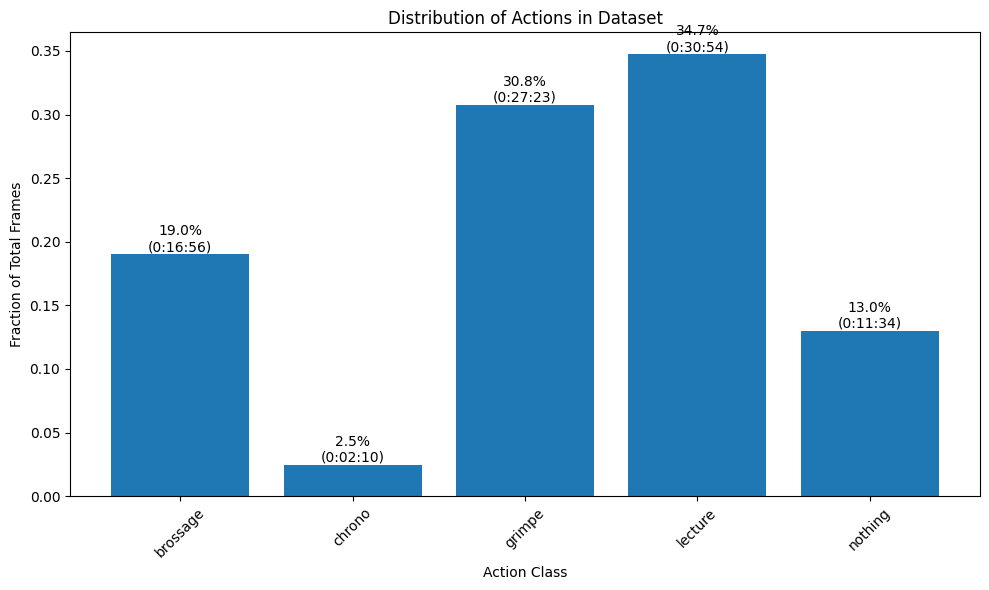

In [78]:
all_annotations = [annotation for _, video_annotations in annotated_videos_dataset for annotation in video_annotations]

unique_classes, counts = np.unique(all_annotations, return_counts=True)
total_frames = len(all_annotations)

fractions = counts / total_frames

durations = [str(timedelta(seconds=int(count/fps))) for count in counts]

plt.figure(figsize=(10, 6))
plt.bar(unique_classes, fractions)
plt.title('Distribution of Actions in Dataset')
plt.xlabel('Action Class')
plt.ylabel('Fraction of Total Frames')
plt.xticks(rotation=45)

for i, (v, d) in enumerate(zip(fractions, durations)):
    plt.text(i, v, f'{v:.1%}\n({d})', ha='center', va='bottom')

plt.tight_layout()


<div class="alert alert-info">

#### **Average Action Duration:**

</div>

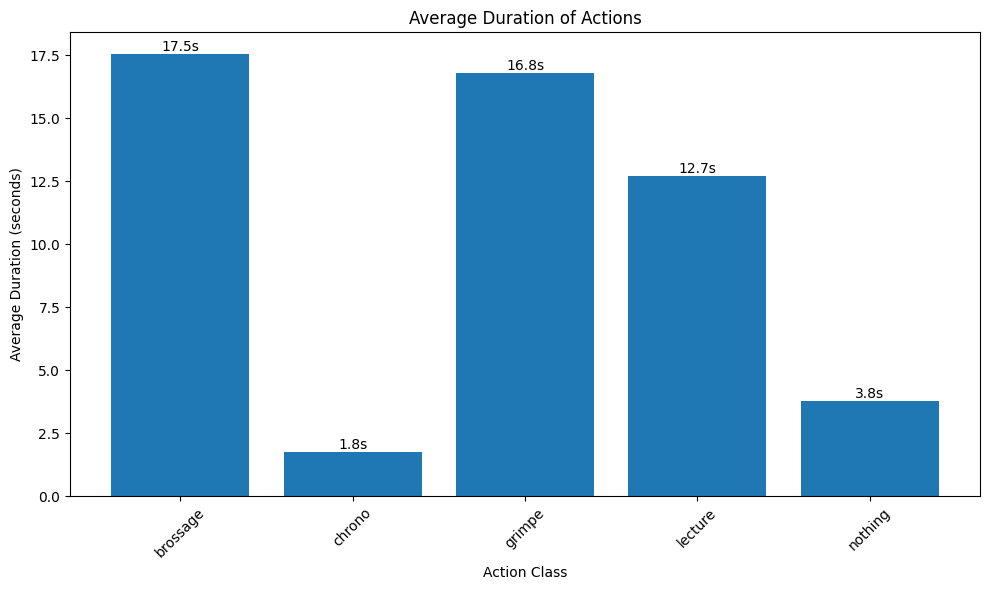

In [80]:
# Calculate average duration in seconds for each class
average_durations = []
for class_name, count in zip(unique_classes, counts):
    # Get all sequences of this class
    sequences = []
    current_sequence = 0
    
    for annotation in all_annotations:
        if annotation == class_name:
            current_sequence += 1
        elif current_sequence > 0:
            sequences.append(current_sequence)
            current_sequence = 0
    
    if current_sequence > 0:
        sequences.append(current_sequence)
    
    # Calculate average duration in seconds
    avg_duration = np.mean(sequences) / fps if sequences else 0
    average_durations.append(avg_duration)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(unique_classes, average_durations)
plt.title('Average Duration of Actions')
plt.xlabel('Action Class')
plt.ylabel('Average Duration (seconds)')
plt.xticks(rotation=45)

# Add duration labels on top of bars
for i, duration in enumerate(average_durations):
    plt.text(i, duration, f'{duration:.1f}s', ha='center', va='bottom')

plt.tight_layout()

<div class="alert alert-info">

#### **Average Actions Number:**

</div>

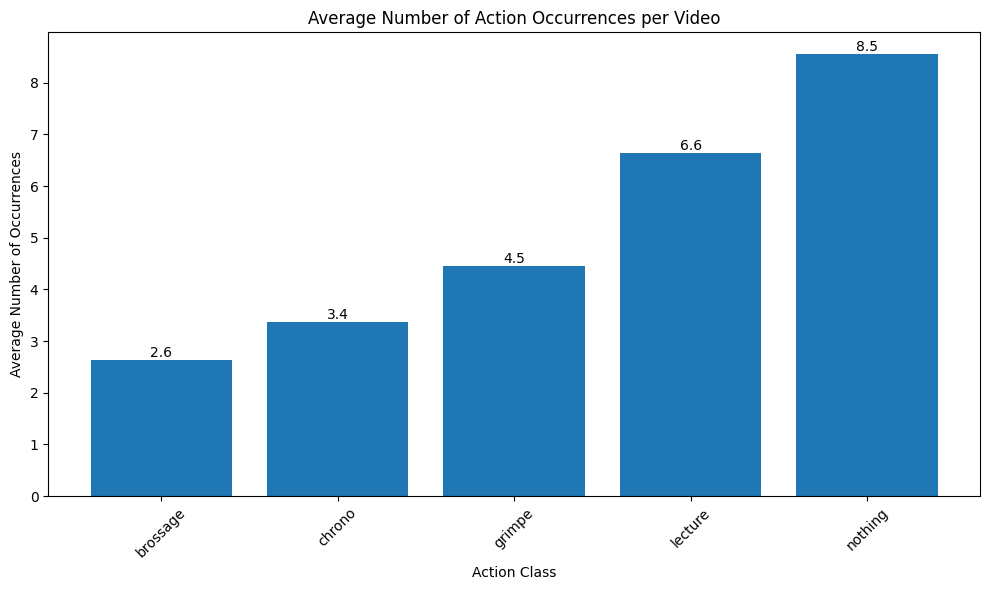

In [83]:
# Calculate number of occurrences of each action type
action_sequences = []
for video_annotation in videos_annotations:
    current_action = video_annotation[0]
    current_count = 1
    sequence_counts = {action: 0 for action in unique_classes}
    
    for action in video_annotation[1:]:
        if action != current_action:
            sequence_counts[current_action] += 1
            current_action = action
    
    # Don't forget to count the last sequence
    sequence_counts[current_action] += 1
    action_sequences.append(sequence_counts)
    
# Calculate average occurrences
average_occurrences = {action: 0 for action in unique_classes}
for action in unique_classes:
    counts = [seq[action] for seq in action_sequences]
    average_occurrences[action] = np.mean(counts)

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(unique_classes, list(average_occurrences.values()))
plt.title('Average Number of Action Occurrences per Video')
plt.xlabel('Action Class')
plt.ylabel('Average Number of Occurrences')
plt.xticks(rotation=45)

# Add value labels on top of bars
for i, v in enumerate(average_occurrences.values()):
    plt.text(i, v, f'{v:.1f}', ha='center', va='bottom')

plt.tight_layout()

<div class="alert alert-info">

#### **Segmentations Visualizations Examples:**

</div>

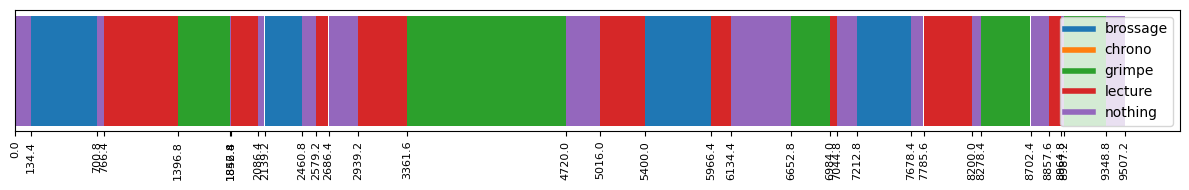

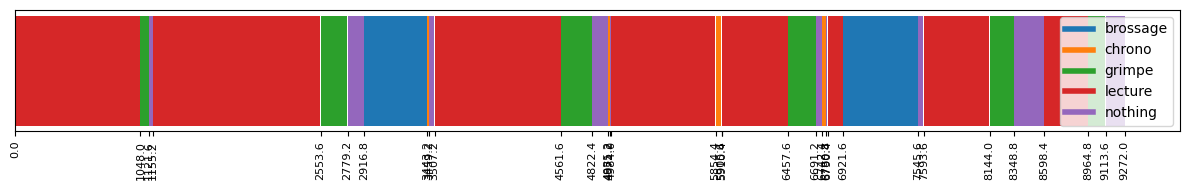

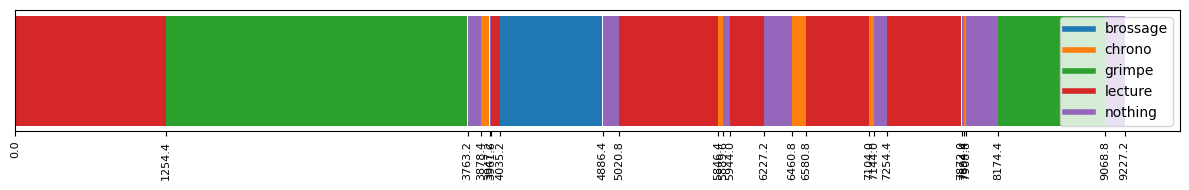

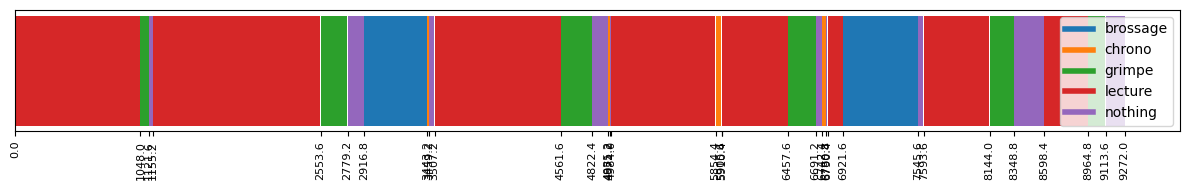

In [79]:
visualizer = SegmentationVisualizer(label_encoder.classes_)

random_indices = np.random.choice(22, 4, replace=False)

for index in random_indices:
    visualizer.plot_segmentation(annotated_videos_dataset[index][1], VIDEO_FPS)